# Introduction to Python Active Learning (PyAL)
PyAL is developed to solve a large range of Active Learning problems by making use of so called acquisition functions. 
This enables to choose from a broad range of settings for running the Active Learning. PyAL enables pool based learning as well as population based learning. It also allows to find several suggested data points in one iteration. 
By the choice of the acquisition function one can control whether the model function that approximates the true data is optimized only close to the maximum in order to find that maximum or whether the full model function is optimized. 
PyAL is compatible with most of sklearns regression models and also can use linear regression models.

The usage of PyAL is very simple. First, we need to import some libraries.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PyAL.models import inv_sphere
from PyAL.optimize import run_continuous_batch_learning

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

random_state=41

Now, we create some test data by first setting some parameters. For this basic example, we use only 1D data with a grid spacing of 100 data points in any dimension in the intervall [-2,2]. 

In [23]:
#Parameters for grid
grid_size = 100     #Number of data points per dimension
dimensions = 1      #Number of dimensions
lim = [[-2,],[2,]]  #Bounds for each dimension. First lower bounds, than upper bounds

#Create a grid for arbitrary number of dimensions
x = []
[x.append(np.linspace(lim[0][i],lim[1][i], grid_size )) for i in range(dimensions)]
pool = np.meshgrid(*x)
pool = np.array(pool).T
test_pool = pool.reshape(grid_size**dimensions, dimensions)
test_pool

array([[-2.        ],
       [-1.95959596],
       [-1.91919192],
       [-1.87878788],
       [-1.83838384],
       [-1.7979798 ],
       [-1.75757576],
       [-1.71717172],
       [-1.67676768],
       [-1.63636364],
       [-1.5959596 ],
       [-1.55555556],
       [-1.51515152],
       [-1.47474747],
       [-1.43434343],
       [-1.39393939],
       [-1.35353535],
       [-1.31313131],
       [-1.27272727],
       [-1.23232323],
       [-1.19191919],
       [-1.15151515],
       [-1.11111111],
       [-1.07070707],
       [-1.03030303],
       [-0.98989899],
       [-0.94949495],
       [-0.90909091],
       [-0.86868687],
       [-0.82828283],
       [-0.78787879],
       [-0.74747475],
       [-0.70707071],
       [-0.66666667],
       [-0.62626263],
       [-0.58585859],
       [-0.54545455],
       [-0.50505051],
       [-0.46464646],
       [-0.42424242],
       [-0.38383838],
       [-0.34343434],
       [-0.3030303 ],
       [-0.26262626],
       [-0.22222222],
       [-0

Next, we define a data_model. The data model represents the true underlying data in this case. We sample data from this model, where we can also decide that this data is noisy. Therefore, we set the noise parameter.

In [24]:
#Data model
data_model = inv_sphere(d=dimensions, random_state=random_state)
noise = np.sqrt(1e-6)

Then, we define a machine learning model that is used to approximate the true data. Here, we decide for a Gaussian Process Regression model with the standard RBF kernel and an additional WhiteKernel.

In [25]:
kernel = RBF(length_scale=1, length_scale_bounds=[0.05,100])+WhiteKernel()
regression_model = GPR(kernel)

Now, we are equipped with everything to start the actual active learning routine. But before we call this routine, we need to define some parameters. Most parameters have default values that you can look up in the documentation.

In [32]:
initial_samples=5  #Number of initial data points 
max_samples=30     #Number of data points that are maximally acquired 
batch_size=5        #Collect data points in batches of five before evaluating the model with a test data set
n_repetitions=1     #Repeat the active learning only once
  
initialization_method = 'random'   #Algorithm to collect initial data
optimization_method = 'PSO'        #Algorithm to search for the maximum of the acquisition function. Choose from 'PSO' or 'lbfgs'AttributeError
n_jobs = 1                         #Number of jobs to start for parallel computing

pso_options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'p':10*dimensions, 'i':50}  #Options for particle swarm optimization

active_learning_steps = int((max_samples-initial_samples)/batch_size) #Number of AL steps is calculated automatically

In this example, we want to compare the performance of 4 different acquisition functions, which we define below. In the dictionary, we save the name of the acquisition function together with a hyperparameter alpha. This is only used for the 'ideal' algorithm here.

In [33]:
acquisition_functions = {'random':[0], 'ideal': [10], 'std': [0], 'GSx':[0]} 

To save the results, we create a dictionary that contains an empty data frame for each acquisition function. 

In [41]:
score_dict = {}
for acquisition_function, alpha_values in acquisition_functions.items():
    for alpha in alpha_values:
        key = acquisition_function+'_'+str(alpha)
        score_dict[key] = pd.DataFrame()

score_dict

{'random_0': Empty DataFrame
 Columns: []
 Index: [],
 'ideal_10': Empty DataFrame
 Columns: []
 Index: [],
 'std_0': Empty DataFrame
 Columns: []
 Index: [],
 'GSx_0': Empty DataFrame
 Columns: []
 Index: []}

No, we run the Active Learning algorithm. We repeat the AL experiment only once here, so the first loop is currently of no relevance. However, you can increase n_repetitions to run several AL experiments with different random seeds. For getting meaningful results when comparing different algorithms, it is suggested to run the AL experiment several times. 
Note that in the final application the AL experiment is only run once and without testing the models.

In [42]:
for i in range(n_repetitions):
    random_state += 1
    
    for acquisition_function, alpha_values in acquisition_functions.items():
        for alpha in alpha_values:
            print(acquisition_function, alpha)

            samples, result = run_continuous_batch_learning(data_model, 
            regression_model,
            acquisition_function = acquisition_function,
            opt_method = optimization_method,
            pool = test_pool, 
            batch_size=batch_size,
            noise=noise,
            initial_samples=initial_samples, 
            active_learning_steps=active_learning_steps,
            lim=lim,
            alpha=alpha,
            n_jobs=n_jobs,
            random_state=random_state,
            calculate_test_metrics=True,
            initialization=initialization_method,
            pso_options=pso_options
            )

            key = acquisition_function+'_'+str(alpha)
            score_dict[key] = pd.concat([score_dict[key], result])

random 0
ideal 10
std 0
GSx 0


As an output we get the acquired data points in the order they were acquired and also the result data frame which we save. You can see how this data frame looks like below. The mean squared error (MSE) the maximum error (MaxE), the mean absolute error (MAE) and the maximum observed value are stored.

In [43]:
score_dict['random_0']

,m,mean_MSE_train,mean_MAE_train,mean_MaxE_train,mean_MSE_test,mean_MAE_test,mean_MaxE_test,max_observation
0,5.0,0.022282,0.139239,0.203310,0.790836,0.511746,2.834259,-0.001652
1,10.0,0.000003,0.001307,0.002930,0.006446,0.042769,0.438585,-0.001652
2,15.0,0.000002,0.001148,0.002841,0.000373,0.008979,0.102833,-0.001652
3,20.0,0.000003,0.001405,0.003578,0.000169,0.004992,0.087969,-0.001652
4,25.0,0.000003,0.001277,0.003782,0.000146,0.004689,0.081639,-0.001652
5,30.0,0.000003,0.001267,0.003703,0.000149,0.004694,0.082585,-0.001652


We can now for example compare the MSE of the 4 different acquisition functions. We observe that all 3 AL algorithms perform better than just randomly choosing data points.

Text(0.5, 0, 'Data points')

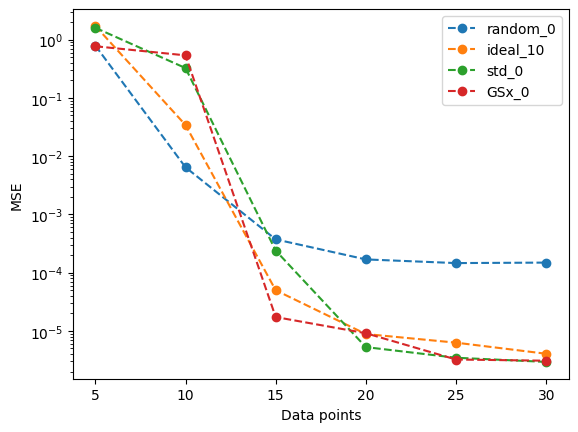

In [47]:
for key, df in score_dict.items():
    plt.plot(df['m'], df['mean_MSE_test'], 'o--', label=key)
plt.legend()
plt.yscale('log')
plt.ylabel('MSE')
plt.xlabel('Data points')